## Imports

In [1]:
# Data manipulation
import time
import numpy as np
import pandas as pd
# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
# KERAS
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Fine-Tune your Neural Network and Save it

🎯 **Goals of this challenge**

1. ⚙️ **Fine-tune the optimizer** of a Neural Network
2. 💾 **Save**/**Load** a trained Neural Network

## (0) The Boston Housing Dataset

📚 `Tensorflow.Keras` has several built-in datasets that you can find [here](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

🏠 Out of those, we are going to use the **Boston Housing Dataset**.

Our mission is to **predict the values of the houses in USD (thousands)**, and we will measure the performance of our models using the _Mean Absolute Error (MAE)_ metric.

### (0.1) Loading the Dataset

In [2]:
# Loading the dataset:
(X_train, y_train), (X_test, y_test) = boston_housing.load_data()

In [3]:
# Shape of the dataset: 
(X_train.shape, y_train.shape), (X_test.shape, y_test.shape)

(((404, 13), (404,)), ((102, 13), (102,)))

### (0.2) Quick Glance at the Target

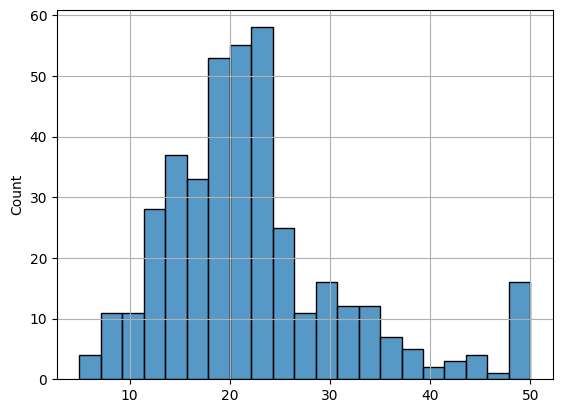

In [4]:
# Distribution of the houses' prices in the training set
sns.histplot(y_train)
plt.grid(True)
plt.show();

In [5]:
# Null values and types of each feature:
pd.DataFrame(X_train).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       404 non-null    float64
 1   1       404 non-null    float64
 2   2       404 non-null    float64
 3   3       404 non-null    float64
 4   4       404 non-null    float64
 5   5       404 non-null    float64
 6   6       404 non-null    float64
 7   7       404 non-null    float64
 8   8       404 non-null    float64
 9   9       404 non-null    float64
 10  10      404 non-null    float64
 11  11      404 non-null    float64
 12  12      404 non-null    float64
dtypes: float64(13)
memory usage: 41.2 KB


In [6]:
# Statistics about the numerical columns
pd.DataFrame(X_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


### (0.3) Minimal Data Preprocessing

#### ❓Scaling your Features


In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### (0.4) Baseline Model

In [8]:
y_pred = np.mean(y_train)
print(f'The mean prediction is {y_pred:.3f}')

absolute_error_test_baseline = [np.abs(y_true - y_pred) for y_true in y_test]
mean_absolute_error_test_baseline = np.mean(absolute_error_test_baseline)
print(f'The benchmark mean absolute error is {mean_absolute_error_test_baseline:.3f}')

The mean prediction is 22.395
The benchmark mean absolute error is 6.533


## (1) The Neural Network

### ❓Initializing a Neural Network with a Specific Architecture

Write a function called `initialize_model` that generates a Neural Network with 3 layers:
- Input layer: **10 neurons**, `relu` activation function, and the appropriate input dimension
- Hidden layer: **7 neurons** and the `relu` activation function
- Predictive layer: an appropriate layer corresponding to the problem we are trying to solve

In [9]:
def initialize_model(x_train_shape):

    model = models.Sequential()
    model.add(layers.Dense(10, activation='relu', input_dim=x_train_shape))
    model.add(layers.Dense(7, activation='relu'))
    model.add(layers.Dense(1, activation='linear'))

    return model 

#### ❓Number of Parameters

In [10]:
model = initialize_model(X_train.shape[-1])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                140       
                                                                 
 dense_1 (Dense)             (None, 7)                 77        
                                                                 
 dense_2 (Dense)             (None, 1)                 8         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## (2) The Optimizer

### ❓Compiling Method

Write a function that:
1. takes _both_ a **model** and an **optimizer** as arguments
2. **compiles** the model
3. returns the compiled model

In [11]:
def compile_model(model, optimizer_name):
    model.compile(
        loss='mse', 
        optimizer=optimizer_name, 
        metrics=['mae']
    ) 
    return model 

### ❓Evaluating the Model

- Initialize the model and compile it with the `adam` optimizer
- Fit it on the training data
- Evaluate your model on the testing data

In [12]:
model = compile_model(model, 'adam')

In [13]:
%%time
es = EarlyStopping(patience = 10, restore_best_weights = True)
model.fit(
    X_train_scaled,
    y_train,
    validation_split = 0.3,
    epochs = 1000,
    batch_size = 16, 
    verbose = 0, 
    shuffle = True,
    callbacks = [es] 
)
res = model.evaluate(X_test_scaled, y_test)[1]
res



4/4 [==============================] - 0s 4ms/step - loss: 25.5355 - mae: 3.0460
CPU times: total: 38.1 s
Wall time: 28.6 s


3.046039581298828

### Neural Network vs. Baseline

Compare the MAE on the testing set between this Neural Network and the baseline model.

In [14]:
mae_test_baseline = mean_absolute_error_test_baseline
mae_test_neuralnet = res
print(f'The MAE on the test is {mae_test_neuralnet:.4f} for the Neural Network vs. {mae_test_baseline:.4f} for the baseline')

The MAE on the test is 3.0460 for the Neural Network vs. 6.5330 for the baseline


### (2.1) Which Optimizer is the Best? 

#### ❓Trying Different Optimizers

In [15]:
def plot_loss_mae(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['mae'])
    ax2.plot(history.history['val_mae'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('MAE')
    ax2.set_ylabel('MAE')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=200)
    ax2.set_ylim(ymin=0, ymax=20)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)

    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)

    plt.show() 

In [16]:
def plot_loss_mse(history):
    # Setting figures
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(13,4))

    # Create the plots
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax2.plot(history.history['mse'])
    ax2.plot(history.history['val_mse'])

    # Set titles and labels
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    ax2.set_title('MSE')
    ax2.set_ylabel('MSE')
    ax2.set_xlabel('Epoch')

    # Set limits for y-axes
    ax1.set_ylim(ymin=0, ymax=20)
    ax2.set_ylim(ymin=0, ymax=200)

    # Generate legends
    ax1.legend(['Train', 'Validation'], loc='best')
    ax2.legend(['Train', 'Validation'], loc='best')

    # Show grids
    ax1.grid(axis="x",linewidth=0.5)
    ax1.grid(axis="y",linewidth=0.5)

    ax2.grid(axis="x",linewidth=0.5)
    ax2.grid(axis="y",linewidth=0.5)

    plt.show()

#### Neural Network vs. Baseline - Part 2

Are your predictions better than those of the baseline model you evaluated at the beginning of the notebook?

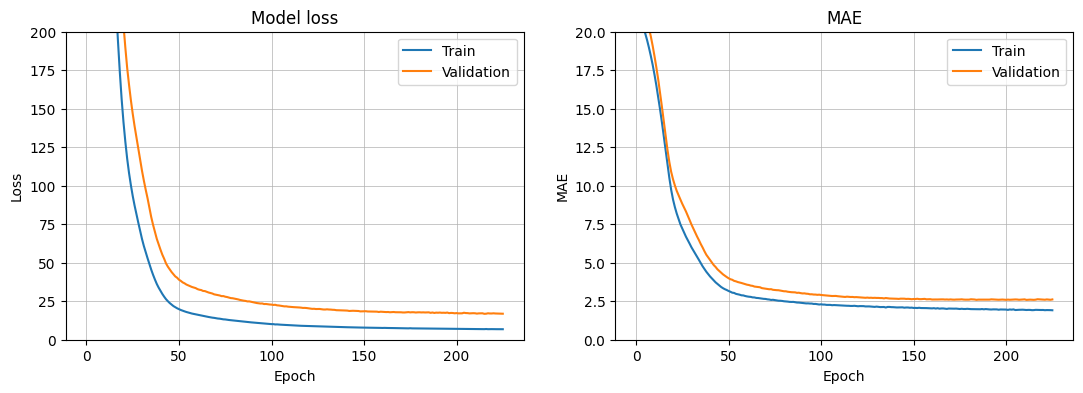

4/4 [==============================] - 0s 3ms/step - loss: 17.5067 - mae: 2.8090
MAE with the rmsprop optimizer: 2.8090  reached in 27 s after 226 epochs


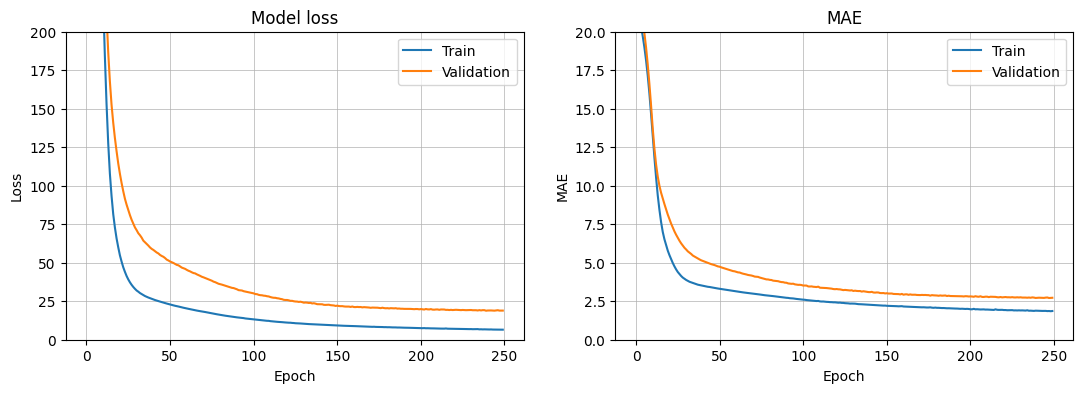

4/4 [==============================] - 0s 4ms/step - loss: 25.1806 - mae: 3.1314
MAE with the adam optimizer: 3.1314  reached in 30 s after 250 epochs


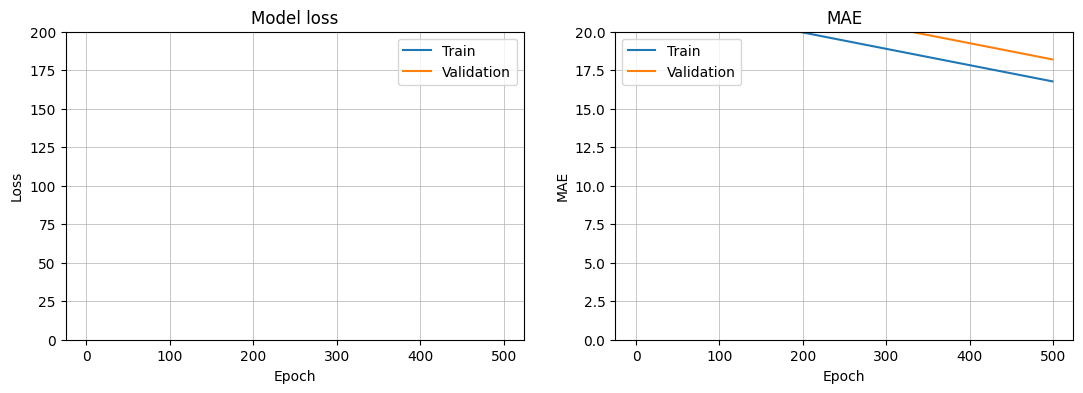

4/4 [==============================] - 0s 3ms/step - loss: 388.9227 - mae: 17.8958
MAE with the adagrad optimizer: 17.8958  reached in 57 s after 500 epochs


In [17]:
results = []

for optimizer in ['rmsprop', 'adam', 'adagrad']:
    start_time = time.time()

    model = compile_model(initialize_model(X_train.shape[-1]), optimizer)

    es = EarlyStopping(patience = 10, restore_best_weights = True)

    history = model.fit(
        X_train_scaled,
        y_train, 
        batch_size = 16, 
        epochs = 500, 
        validation_split = 0.3,
        callbacks = [es], 
        verbose = 0
    )
    plot_loss_mae(history)
    res = model.evaluate(X_test_scaled, y_test)[1]
    results.append(res)
    end_time = time.time()
    print(f'MAE with the {optimizer} optimizer: {res:.4f}  reached in {(end_time - start_time):.0f} s after {len(history.epoch)} epochs')

In [18]:
# MAE on the testing set for different optimizers
for optimizer, result in zip(['rmsprop', 'adam', 'adagrad'], results):
    print(f'The MAE on the test set with the {optimizer} optimizer is equal to {result:.2f}')

# MAE on the testing set for the baseline model    
print('-'*5)    
print(f'The MAE on the test set with the baseline model is equal to {mae_test_baseline:.2f}')

The MAE on the test set with the rmsprop optimizer is equal to 2.81
The MAE on the test set with the adam optimizer is equal to 3.13
The MAE on the test set with the adagrad optimizer is equal to 17.90
-----
The MAE on the test set with the baseline model is equal to 6.53


### (2.2) The Influence of the Learning Rate

### Selecting an Optimizer with a Custom Learning Rate

📚 [`tf.keras.optimizers.Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam)

Instead of initializing the optimizer with a string, let's initialize an optimizer manually.

- Instantiate an Adam optimizer with a Learning Rate of $ \alpha = 0.1$
    - Keep the other parameters at their default values
- Use this optimizer in the `compile_model` function
- Train/fit the model
- Plot the history
- Evaluate your model

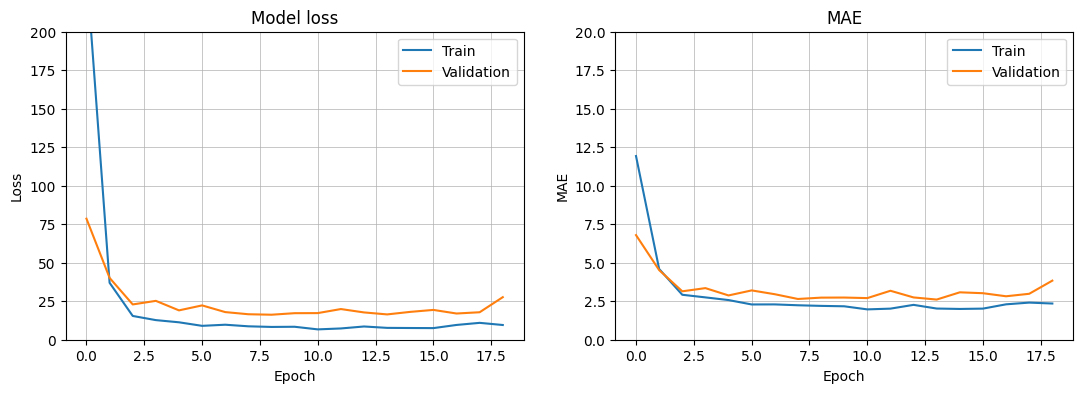

4/4 [==============================] - 0s 4ms/step - loss: 30.7922 - mae: 4.3680
Mean absolute error with a learning rate of 0.1: 4.3680
CPU times: total: 6.98 s
Wall time: 5.6 s


In [19]:
%%time
# 1. Instantiating the Adam optimizer with a learning rate alpha = 0.1
adam = Adam(learning_rate = 0.1)
# 2. Initializing the model
model = initialize_model(X_train.shape[-1])
# 3. Compiling the model with the custom Adam optimizer
model = compile_model(model, adam)
# 4. Training the neural net
es = EarlyStopping(patience = 10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size=16, 
    epochs = 1_000,
    callbacks = [es],
    verbose = 0
)
# 5. Plot the history and evaluate the model
plot_loss_mae(history)
res = model.evaluate(X_test_scaled, y_test)[1]
res
print(f'Mean absolute error with a learning rate of 0.1: {res:.4f}')

### ❓Playing with Learning Rates

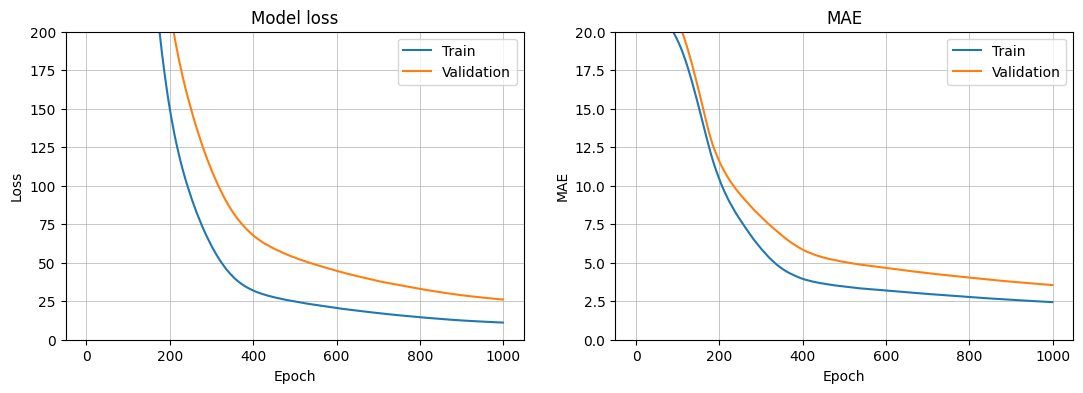

4/4 [==============================] - 0s 4ms/step - loss: 25.8594 - mae: 3.6933
Mean absolute error with a learning rate of 0.0001: 3.6933 reached in 117 s


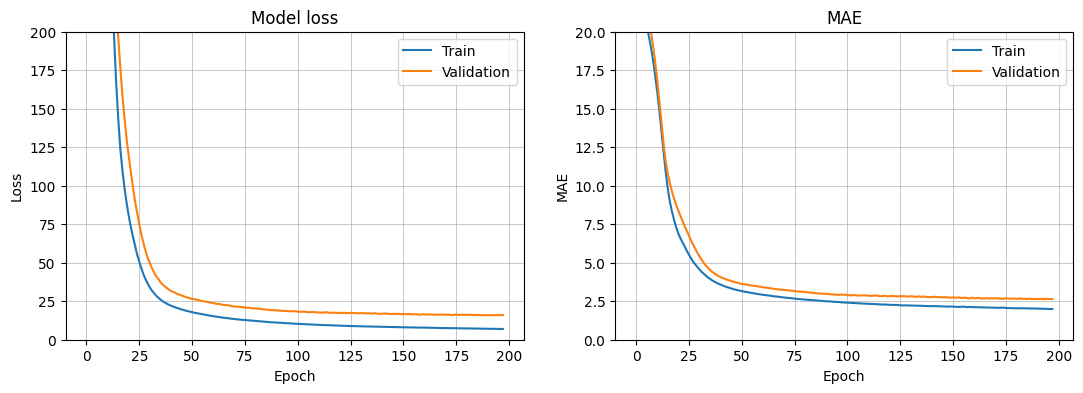

4/4 [==============================] - 0s 4ms/step - loss: 21.2954 - mae: 2.9810
Mean absolute error with a learning rate of 0.001: 2.9810 reached in 26 s


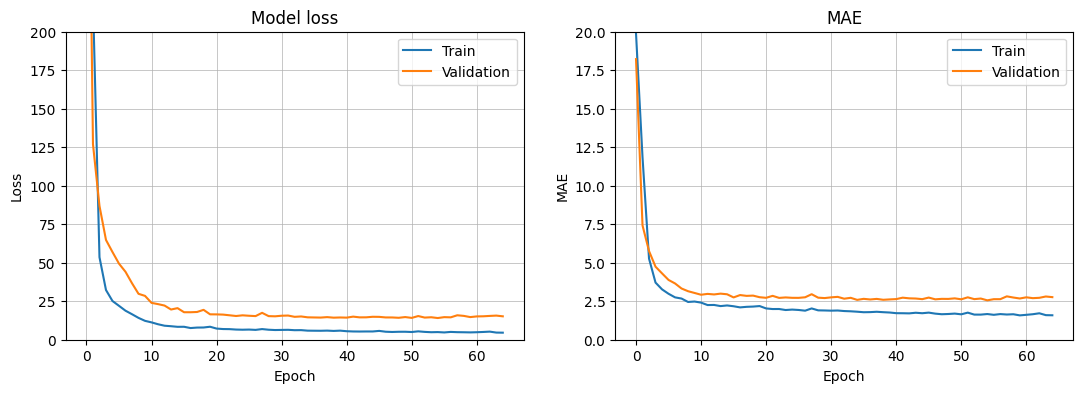

4/4 [==============================] - 0s 4ms/step - loss: 19.6754 - mae: 2.7713
Mean absolute error with a learning rate of 0.01: 2.7713 reached in 11 s


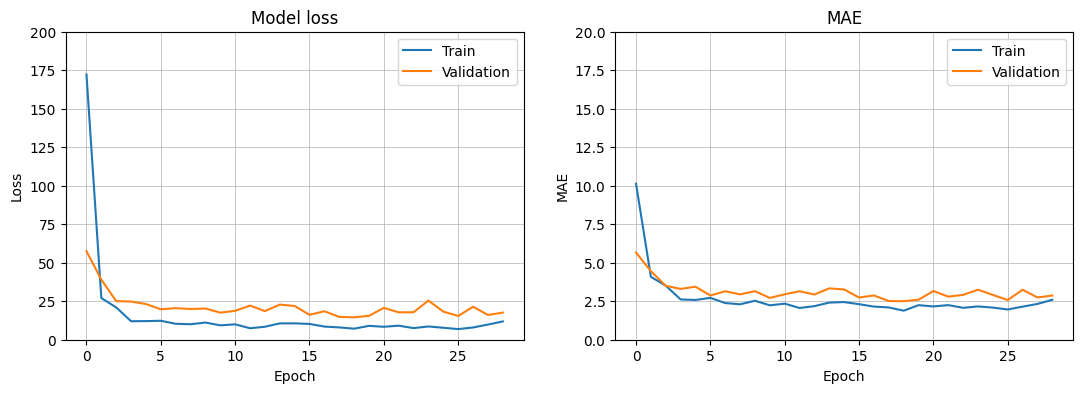

4/4 [==============================] - 0s 5ms/step - loss: 23.3692 - mae: 3.2862
Mean absolute error with a learning rate of 0.1: 3.2862 reached in 7 s


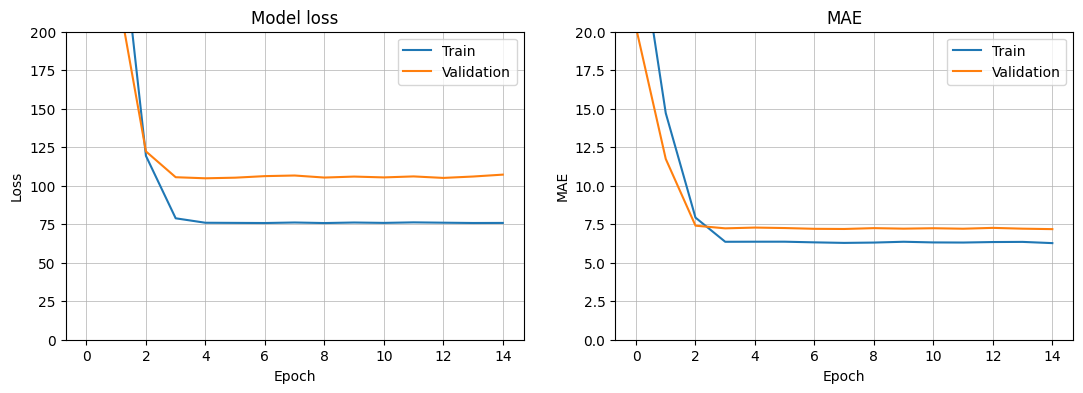

4/4 [==============================] - 0s 4ms/step - loss: 85.5885 - mae: 6.5316
Mean absolute error with a learning rate of 1: 6.5316 reached in 5 s


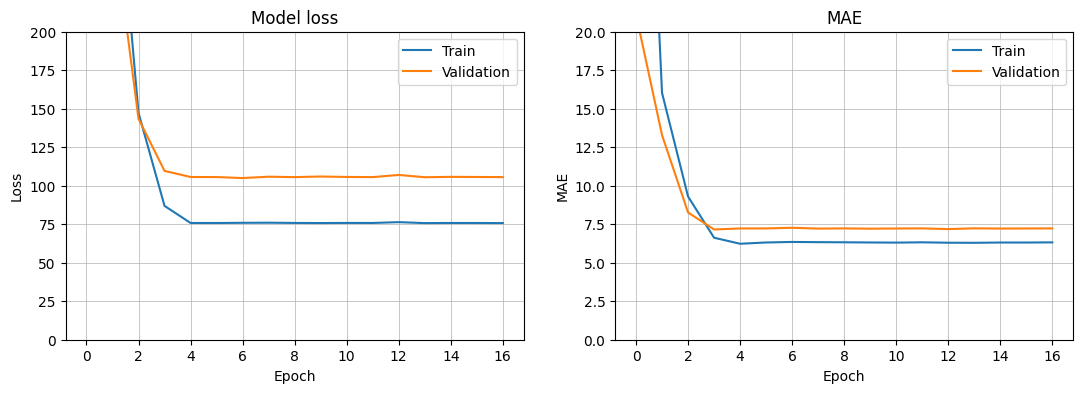

4/4 [==============================] - 0s 6ms/step - loss: 84.2857 - mae: 6.5160
Mean absolute error with a learning rate of 2: 6.5160 reached in 5 s


In [20]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 1, 2]
results = []

for learning_rate in learning_rates:
    start_time = time.time()
    adam = Adam(learning_rate=learning_rate)
    model = compile_model(initialize_model(X_train.shape[-1]), adam)
    es = EarlyStopping(patience = 10)
    history = model.fit(
        X_train_scaled,
        y_train, 
        validation_split = 0.3,
        shuffle = True,
        batch_size=16, 
        epochs = 1000,
        callbacks = [es],
        verbose = 0
    )
    plot_loss_mae(history)
    res = model.evaluate(X_test_scaled, y_test)[1]
    end_time = time.time()
    res
    print(f'Mean absolute error with a learning rate of {learning_rate}: {res:.4f} reached in {(end_time-start_time):.0f} s')

## (3) The Loss

### ❓Optimizing a Model with a certain Loss Function

- Run the same NN, once with `mae` as the loss, and once with `mse`
- In both cases, compare `mae_train`, `mae_val`, `mse_train`, `mse_val`

In [21]:
%%time
model = initialize_model(X_train.shape[-1])
adam = Adam(learning_rate=0.001)
model.compile(loss = 'mae', optimizer = adam, metrics = ['mse'])
es = EarlyStopping(patience = 10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size=16, 
    epochs = 1000,
    callbacks = [es],
    verbose = 0
)
res = model.evaluate(X_test_scaled, y_test)
res

4/4 [==============================] - 0s 3ms/step - loss: 2.7406 - mse: 15.7079
CPU times: total: 38.7 s
Wall time: 28.8 s


[2.740642547607422, 15.707938194274902]

In [22]:
print(f"MAE_train : {min(history.history['loss']):.4f} - MSE_train : {min(history.history['mse']):.4f}")
print(f"MAE_val : {min(history.history['val_loss']):.4f} - MSE_val : {min(history.history['val_mse']):.4f}")
print(f"MAE_test : {res[0]:.4f} - MSE_val : {res[1]:.4f}")

MAE_train : 1.7964 - MSE_train : 8.9376
MAE_val : 2.8640 - MSE_val : 28.1917
MAE_test : 2.7406 - MSE_val : 15.7079


In [23]:
%%time
model = initialize_model(X_train.shape[-1])
adam = Adam(learning_rate=0.001)
model.compile(optimizer= adam, loss='mse', metrics='mae')
es = EarlyStopping(patience = 10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size=16, 
    epochs = 1000,
    callbacks = [es],
    verbose = 0
)
res = model.evaluate(X_test_scaled, y_test)
res

4/4 [==============================] - 0s 3ms/step - loss: 22.7428 - mae: 2.9444
CPU times: total: 36.5 s
Wall time: 27.6 s


[22.742815017700195, 2.944355010986328]

In [24]:
res = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"MAE_train : {min(history.history['mae']):.4f} - MSE_train : {min(history.history['loss']):.4f}")
print(f"MAE_val : {min(history.history['val_mae']):.4f} - MSE_val : {min(history.history['val_loss']):.4f}")
print(f"MAE_test : {res[1]:.4f} - MSE_val : {res[0]:.4f}")

MAE_train : 1.8364 - MSE_train : 6.3834
MAE_val : 2.7335 - MSE_val : 18.5378
MAE_test : 2.9444 - MSE_val : 22.7428


## (4)  Saving and Loading a Trained Neural Network

### ❓Saving a Model

In [25]:
models.save_model(model,'Buga_model')

INFO:tensorflow:Assets written to: Buga_model\assets


INFO:tensorflow:Assets written to: Buga_model\assets


### ❓Loading a Model

In [26]:
loaded_model = models.load_model('Buga_model')

In [27]:
loaded_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 10)                140       
                                                                 
 dense_37 (Dense)            (None, 7)                 77        
                                                                 
 dense_38 (Dense)            (None, 1)                 8         
                                                                 
Total params: 225 (900.00 Byte)
Trainable params: 225 (900.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
res_from_loaded_model = loaded_model.evaluate(X_test_scaled, y_test, verbose = 0)[1]
res_from_loaded_model

2.944355010986328

In [29]:
res_from_loaded_model == res[1]

True

## (5) (Optional) Exponential Decay

### ❓The Exponential Decay Scheduler

In [30]:
X_train.shape[0] * 0.7 / 16

17.674999999999997

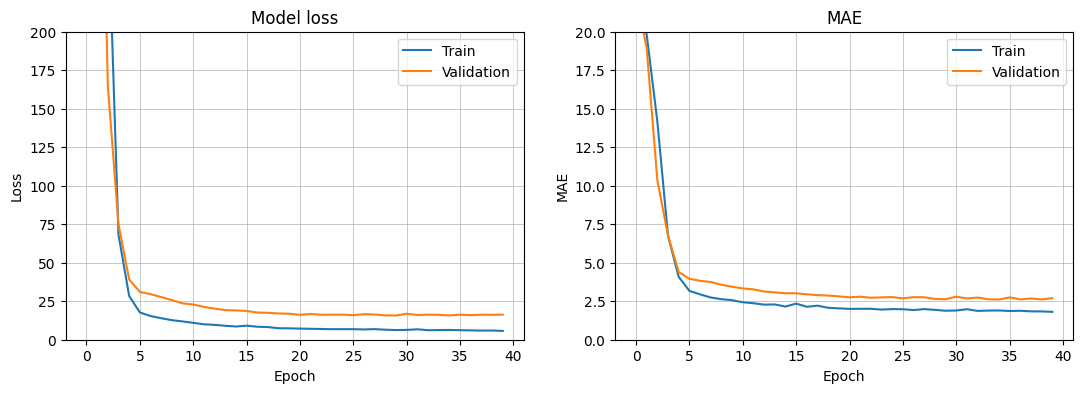

4/4 [==============================] - 0s 3ms/step - loss: 17.8878 - mae: 2.9719
Mean absolute error : 2.9719
CPU times: total: 8.8 s
Wall time: 7.14 s


In [31]:
%%time
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01, 
    decay_steps = 5000,    
    decay_rate = 0.5      
)
adam = Adam(learning_rate=lr_schedule)
model = compile_model(initialize_model(X_train.shape[-1]), optimizer_name=adam)
es = EarlyStopping(patience=10)
history = model.fit(
    X_train_scaled,
    y_train, 
    validation_split = 0.3,
    shuffle = True,
    batch_size = 16, 
    epochs = 1000, 
    callbacks = [es], 
    verbose = 0
)
plot_loss_mae(history)
res = model.evaluate(X_test_scaled, y_test)[1]
print(f"Mean absolute error : {res:.4f}")